<a href="https://colab.research.google.com/github/a9e68ce5/Machine-Learning/blob/main/RNN%20for%20Text%20Sentiment%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW4 RNN
Task: Sentiment classification on Twitter comments.

Goal of this homework:
*   Get familiar with the recurrent neural network.
*   Learn how to deal with text data

TA: Chih-Kai, Yang (b08202033@ntu.edu.tw)



# ***Import packages.***

In [ ]:

import os
import csv
import random
import numpy as np
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import re

from torch.nn.utils.rnn import pad_sequence
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from torch import optim

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
import torch

# ***Download the dataset and unzip it.***

In [ ]:
!wget https://www.dropbox.com/s/0abp8vvib4j1gjw/HW4_dataset.zip
!mv HW4_dataset.zip DATASET.zip

--2022-11-27 02:01:15--  https://www.dropbox.com/s/0abp8vvib4j1gjw/HW4_dataset.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/0abp8vvib4j1gjw/HW4_dataset.zip [following]
--2022-11-27 02:01:16--  https://www.dropbox.com/s/raw/0abp8vvib4j1gjw/HW4_dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc88a5150f68f9fe35f990851d5.dl.dropboxusercontent.com/cd/0/inline/Bxh-w0aZNbvX-TbX3GZ-rqegdOydXOmgVeg6QkJwa-WS3yBBwAnCeVNuRI_5C9fm1K9nGPC1sCR39JOHv2RCB6G54WNspM0HIIR-iDeKfXfkt-PBlXvJ1Hlsl8M8I04p99tdZC6vb2Eg3L-fHWh5nEuvo62zVoBcK4T3gBNLtvvNKQ/file# [following]
--2022-11-27 02:01:16--  https://ucc88a5150f68f9fe35f990851d5.dl.dropboxusercontent.com/cd/0/inline/Bxh-w0aZNbvX-TbX3GZ-rqegdOydXOmgVeg6QkJwa-WS3yBBwAnCeVNuRI_5C9fm1K9n

In [ ]:
#!gdown --id "1cwPgbbAMNPZ9nCoyOW2WuavimYymCKKy" --output DATASET.zip

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1hW0UvoM7aU6KRSXLJlkFkDW80O1Fiopo
To: /content/testQ51_2.csv
100% 140/140 [00:00<00:00, 267kB/s]


In [ ]:
!pip list

Package                       Version
----------------------------- ----------------------
absl-py                       1.3.0
aeppl                         0.0.33
aesara                        2.7.9
aiohttp                       3.8.3
aiosignal                     1.3.1
alabaster                     0.7.12
albumentations                1.2.1
altair                        4.2.0
appdirs                       1.4.4
arviz                         0.12.1
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
async-timeout                 4.0.2
asynctest                     0.13.0
atari-py                      0.2.9
atomicwrites                  1.4.1
attrs                         22.1.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.11.0
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        5.0.1
blis                          0.7.9
bokeh

In [ ]:
!unzip DATASET.zip

Archive:  DATASET.zip
  inflating: HW4_dataset/test.csv    
  inflating: HW4_dataset/train.csv   
  inflating: HW4_dataset/train_nolabel.csv  


# ***Basic setup of hyperparameters***

In [ ]:
BATCH_SIZE = 256 #256
EPOCH_NUM = 200
MAX_POSITIONS_LEN = 120
SEED = 7414 # Set your lucky number as the random seed
MODEL_DIR = 'model.pth'
MODEL_DIR2 = 'super_model.pth'
lr = 1e-5


torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')# 'cuda' if torch.cuda.is_available() else

w2v_config = {'path': 'w2v.model', 'dim': 70}#'dim': 70
net_config = {'hidden_dim': 256, 'num_layers': 3, 'bidirectional': False, 'fix_embedding': False}#'num_layers': 1'hidden_dim': 64
header_config = {'dropout': 0.5, 'hidden_dim': 256}#'hidden_dim': 64{'dropout': 0.5
assert header_config['hidden_dim'] == net_config['hidden_dim'] or header_config['hidden_dim'] == net_config['hidden_dim'] * 2

# ***Auxiliary functions and classes definition***

In [ ]:
def parsing_text(text):

    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text = url_pattern.sub(r'', text)

    # Remove @
    text = re.sub('@\S+', '', text)

    # Remove Emails
    text = re.sub('\S*@\S*\s?', '', text)

    # Remove new line characters
    text = re.sub('\s+', ' ', text)

    # Remove distracting single quotes
    text = re.sub("\'", "", text)

    return text

def load_train_label(path='HW4_dataset/train.csv'):
    tra_lb_pd = pd.read_csv(path)
    label = torch.FloatTensor(tra_lb_pd['label'].values)
    idx = tra_lb_pd['id'].tolist()
    text = [parsing_text(s).split(' ') for s in tra_lb_pd['text'].tolist()]
    return idx, text, label

def load_train_nolabel(path='HW4_dataset/train_nolabel.csv'):
    tra_nlb_pd = pd.read_csv(path)
    idx = tra_nlb_pd['id'].tolist()
    text = [parsing_text(s).split(' ') for s in tra_nlb_pd['text'].tolist()]
    return idx, text

def load_test(path='HW4_dataset/test.csv'):
    tst_pd = pd.read_csv(path)
    idx = tst_pd['id'].tolist()
    text = [parsing_text(s).split(' ') for s in tst_pd['text'].tolist()]
    return idx, text

In [ ]:
class Preprocessor:
    def __init__(self, sentences, w2v_config):
        self.sentences = sentences
        self.idx2word = []
        self.word2idx = {}
        self.embedding_matrix = []
        self.build_word2vec(sentences, **w2v_config)

    def build_word2vec(self, x, path, dim):
        if os.path.isfile(path):
            print("loading word2vec model ...")
            w2v_model = Word2Vec.load(path)
        else:
            print("training word2vec model ...")
            w2v_model = Word2Vec(x, size=dim, window=10, min_count=5, workers=12, iter=60, sg=0)#將字詞轉換成向量的形式，將文本的內容轉換成向量空間中的向量運算
            #(data,size:轉成向量的維度,window:周圍詞彙要看多少範圍,min_count:詞彙少於min_count的不會參與訓練,workers:訓練的並行數量,iter:epoch數，sg=skip-gram)#window=9
            print("saving word2vec model ...")
            w2v_model.save(path)
        # 把之前訓練好的 word to vec 模型讀進來
        self.embedding_dim = w2v_model.vector_size
        # 製作一個 word2idx 的 dictionary
        # 製作一個 idx2word 的 list
        # 製作一個 word2vector 的 list
        for i, word in enumerate(w2v_model.wv.vocab):
            #e.g. self.word2index['he'] = 1
            #e.g. self.index2word[1] = 'he'
            #e.g. self.vectors[1] = 'he' vector
            # 把 word 加進 embedding，並賦予他一個隨機生成的 representation vector
            self.word2idx[word] = len(self.word2idx)
            self.idx2word.append(word)
            self.embedding_matrix.append(w2v_model[word])
        # word 只會是 "<PAD>" 或 "<UNK>"
        self.embedding_matrix = torch.tensor(self.embedding_matrix)
        self.add_embedding('<PAD>')
        self.add_embedding('<UNK>')
        print("total words: {}".format(len(self.embedding_matrix)))

    def add_embedding(self, word):
        vector = torch.empty(1, self.embedding_dim)
        torch.nn.init.uniform_(vector)
        self.word2idx[word] = len(self.word2idx)
        self.idx2word.append(word)
        self.embedding_matrix = torch.cat([self.embedding_matrix, vector], 0)

    def sentence2idx(self, sentence):
      # 把句子裡面的字轉成相對應的 index
        sentence_idx = []
        for word in sentence:
            if word in self.word2idx.keys():
                sentence_idx.append(self.word2idx[word])
            else:
                sentence_idx.append(self.word2idx["<UNK>"])
        return torch.LongTensor(sentence_idx)

class TwitterDataset(torch.utils.data.Dataset):
    def __init__(self, id_list, sentences, labels, preprocessor):
        self.id_list = id_list
        self.sentences = sentences
        self.labels = labels
        self.preprocessor = preprocessor

    def __getitem__(self, idx):
        if self.labels is None: return self.id_list[idx], self.preprocessor.sentence2idx(self.sentences[idx])
        return self.id_list[idx], self.preprocessor.sentence2idx(self.sentences[idx]), self.labels[idx]

    def __len__(self):
        return len(self.sentences)

    def collate_fn(self, data):
        id_list = torch.LongTensor([d[0] for d in data])#建構一個long類型的tensor
        lengths = torch.LongTensor([len(d[1]) for d in data])
        texts = pad_sequence(
            [d[1] for d in data], batch_first=True).contiguous()

        if self.labels == None:
            return id_list, lengths, texts
        else:
          labels = torch.FloatTensor([d[2] for d in data])
          return id_list, lengths, texts, labels

In [ ]:
train_idx, train_label_text, label = load_train_label('HW4_dataset/train.csv')

In [ ]:
preprocessor = Preprocessor(train_label_text, w2v_config)

training word2vec model ...
saving word2vec model ...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


total words: 22094


In [ ]:
train_idx, valid_idx, train_label_text, valid_label_text, train_label, valid_label = train_test_split(train_idx, train_label_text, label, test_size=0.5)
train_dataset, valid_dataset = TwitterDataset(train_idx, train_label_text, train_label, preprocessor), TwitterDataset(valid_idx, valid_label_text, valid_label, preprocessor)

test_idx, test_text = load_test('HW4_dataset/test.csv')
test_dataset = TwitterDataset(test_idx, test_text, None, preprocessor)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True,
                                            collate_fn = train_dataset.collate_fn,
                                            num_workers = 8)
valid_loader = torch.utils.data.DataLoader(dataset = valid_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = False,
                                            collate_fn = valid_dataset.collate_fn,
                                            num_workers = 8)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = False,
                                            collate_fn = test_dataset.collate_fn,
                                            num_workers = 8)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# ***Definition of RNN network***

In [ ]:
class Backbone(torch.nn.Module):
    def __init__(self, embedding, hidden_dim, num_layers, bidirectional, fix_embedding=True):
        super(Backbone, self).__init__()
        # 製作 embedding layer
        self.embedding = torch.nn.Embedding(embedding.size(0),embedding.size(1))#(所有文本詞彙index的數量，一個詞應該轉換成多少維的向量)
        self.embedding.weight = torch.nn.Parameter(embedding)
        # 是否將 embedding fix 住，如果 fix_embedding 為 False，在訓練過程中，embedding 也會跟著被訓練
        self.embedding.weight.requires_grad = False if fix_embedding else True

        self.net = torch.nn.LSTM(embedding.size(1), hidden_dim, num_layers=num_layers, \
                                  bidirectional=bidirectional, batch_first=True)

    def forward(self, inputs):
        inputs = self.embedding(inputs)
        x, _ = self.net(inputs)
        return x

class Header(torch.nn.Module):
    def __init__(self, dropout, hidden_dim):
        super(Header, self).__init__()
        # TODO: you should design your classifier module
        self.classifier = torch.nn.Sequential(torch.nn.Dropout(dropout),
                            torch.nn.Linear(hidden_dim,1),
                            torch.nn.Sigmoid(),
                            torch.nn.LeakyReLU(negative_slope=0.5),
                            torch.nn.LeakyReLU(negative_slope=0.5))
                            #torch.nn.Linear(256,512),
                            #torch.nn.Sigmoid())
                            #torch.nn.LeakyReLU(negative_slope=0.5),
                            #torch.nn.LeakyReLU(negative_slope=0.5),
                            #torch.nn.ReLU(),
                            #torch.nn.Linear(512,1))
                            #torch.nn.LeakyReLU(negative_slope=0.5))
                            #torch.nn.Sigmoid(),
                            #torch.nn.ReLU(),
                            #torch.nn.Linear(512,1))
                            #torch.nn.LeakyReLU(negative_slope=0.5),
                            #torch.nn.Linear(1024,1))

    @ torch.no_grad()
    def _get_length_masks(self, lengths):
        # lengths: (batch_size, ) in cuda
        ascending = torch.arange(MAX_POSITIONS_LEN)[:lengths.max().item()].unsqueeze(
            0).expand(len(lengths), -1).to(lengths.device)
        length_masks = (ascending < lengths.unsqueeze(-1)).unsqueeze(-1)
        return length_masks

    def forward(self, inputs, lengths):
        # the input shape should be (N, L, D∗H)
        pad_mask = self._get_length_masks(lengths)
        inputs = inputs * pad_mask
        inputs = inputs.sum(dim=1)
        out = self.classifier(inputs).squeeze()
        return out

# ***Early stopping***

In [ ]:
class EarlyStopping(object):
    def __init__(self, mode='max', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True #表示暱名函式（ Anonymous Function ）。
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if np.isnan(metrics):#判斷是否是空值
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

# ***Trainer***

In [ ]:
def train(train_loader, backbone, header, optimizer, criterion, device, epoch):

    total_loss = []
    total_acc = []

    for i, (idx_list, lengths, texts, labels) in enumerate(train_loader):
        lengths, inputs, labels = lengths.to(device), texts.to(device), labels.to(device)

        optimizer.zero_grad()# 由於 loss.backward() 的 gradient 會累加，所以每次餵完一個 batch 後需要歸零
        if not backbone is None:
            inputs = backbone(inputs)# 將 input 餵給模型
        soft_predicted = header(inputs, lengths)
        loss = criterion(soft_predicted, labels)# 計算此時模型的 training loss
        loss.backward()# 算 loss 的 gradient，從loss開始做backpropagation
        optimizer.step() # 更新訓練模型的參數

        with torch.no_grad():
            hard_predicted = (soft_predicted >= 0.5).int()
            correct = sum(hard_predicted == labels).item()
            batch_size = len(labels)

            print('[Validation in epoch {:}] loss:{:.3f} acc:{:.3f}'.format(epoch+1, np.mean(total_loss), np.mean(total_acc)), end='\r')
    backbone.train()#將模式設為 train，這樣 optimizer 就可以更新 model 的參數
    header.train()#將模式設為 train，這樣 optimizer 就可以更新 model 的參數
    return np.mean(total_loss), np.mean(total_acc)

def valid(valid_loader, backbone, header, criterion, device, epoch):
    backbone.eval()# 將 模式設為 eval，這樣 model 的參數就會固定住
    header.eval()# 將 模式設為 eval，這樣 model 的參數就會固定住
    with torch.no_grad():#不做gradient也不做backpropagation
        total_loss = []
        total_acc = []

        for i, (idx_list, lengths, texts, labels) in enumerate(valid_loader):
            lengths, inputs, labels = lengths.to(device), texts.to(device), labels.to(device)

            if not backbone is None:
                inputs = backbone(inputs)
            soft_predicted = header(inputs, lengths)
            loss = criterion(soft_predicted, labels)
            total_loss.append(loss.item())

            hard_predicted = (soft_predicted >= 0.5).int()
            correct = sum(hard_predicted == labels).item()
            acc = correct * 100 / len(labels)
            total_acc.append(acc)

            print('[Validation in epoch {:}] loss:{:.3f} acc:{:.3f}'.format(epoch+1, np.mean(total_loss), np.mean(total_acc)), end='\r')
    backbone.train()# # 將模式設為 train，這樣 optimizer 就可以更新 model 的參數（因為剛剛轉成 eval 模式）
    header.train()# # 將模式設為 train，這樣 optimizer 就可以更新 model 的參數（因為剛剛轉成 eval 模式）
    return np.mean(total_loss), np.mean(total_acc)

def better(acc_record):
    if max(acc_record) == acc_record[-1]: return True
    return False

def run_training(train_loader, valid_loader, backbone, header, epoch_num, lr, device, model_dir, scheduler = None):
    es = EarlyStopping(patience = 10)
    def check_point(backbone, header, acc, acc_record, model_dir):
        if acc>=np.mean(acc_record[-5:]):
          torch.save({'backbone': backbone, 'header': header}, model_dir)#保存整個模型
          print('model saved to %s' % model_dir)
    def is_stop(acc):
        if es.step(acc):
          print("Early stopping at Epoch: {}". format(epoch+1))
          return True
        else:
          return False

    if backbone is None:
        trainable_paras = header.parameters()
    else:
        trainable_paras = list(backbone.parameters()) + list(header.parameters())

    optimizer = torch.optim.Adam(trainable_paras, lr=lr, betas=(0.9,0.999), eps=1e-08, weight_decay=0)# 將模型的參數給 optimizer，並給予適當的 learning rate
    acc_record=[]
    backbone.train()# 將模式設為 train，這樣 optimizer 就可以更新 model 的參數
    header.train()# 將模式設為 train，這樣 optimizer 就可以更新 model 的參數

    backbone = backbone.to(device)# device 為 "cuda"
    header = header.to(device)# device 為 "cuda"
    #if not scheduler:
        #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.6, patience=20) #lr rate schedular(最大化 acc, lr*0.5, parience=5)

    criterion = torch.nn.BCELoss()#binary cross entropy loss#BCEWithLogitsLoss
    for epoch in range(epoch_num):
        train(train_loader, backbone, header, optimizer, criterion, device, epoch)
        loss, acc = valid(valid_loader, backbone, header, criterion, device, epoch)

        acc_record.append(acc)
        print('[Validation in epoch {:}] loss:{:.3f} acc:{:.3f} learning rate: {:}'.format(epoch+1, loss, acc, optimizer.param_groups[0]['lr']))
        #scheduler.step(1)
        if better(acc_record):
          check_point(backbone, header, acc, acc_record, model_dir)
        if is_stop(acc):
            break
    %matplotlib inline
    fig = plt.figure() #定義一個圖像窗口
    plt.title("valid learning curve")
    plt.xlabel("Epoch")
    plt.ylabel("accuracy")
    line1,=plt.plot(acc_record, '-x',color='red',label='valid learning curve') #定義x,y和圖的樣式

# ***Training***

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[Validation in epoch 1] loss:0.630 acc:68.246 learning rate: 1e-05
model saved to model.pth
[Validation in epoch 2] loss:0.595 acc:70.542 learning rate: 1e-05
model saved to model.pth
[Validation in epoch 3] loss:0.579 acc:71.900 learning rate: 1e-05
model saved to model.pth
[Validation in epoch 4] loss:0.567 acc:72.708 learning rate: 1e-05
model saved to model.pth
[Validation in epoch 5] loss:0.556 acc:73.520 learning rate: 1e-05
model saved to model.pth
[Validation in epoch 6] loss:0.546 acc:74.003 learning rate: 1e-05
model saved to model.pth
[Validation in epoch 7] loss:0.537 acc:74.301 learning rate: 1e-05
model saved to model.pth
[Validation in epoch 8] loss:0.529 acc:74.578 learning rate: 1e-05
model saved to model.pth
[Validation in epoch 9] loss:0.523 acc:74.830 learning rate: 1e-05
model saved to model.pth
[Validation in epoch 10] loss:0.520 acc:74.994 learning rate: 1e-05
model saved to model.pth
[Validation in epoch 11] loss:0.516 acc:75.130 learning rate: 1e-05
model saved

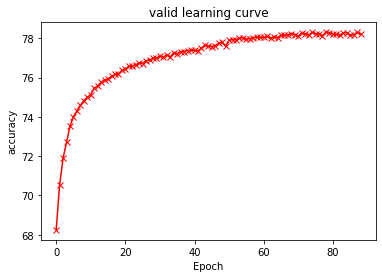

In [ ]:
backbone = Backbone(preprocessor.embedding_matrix, **net_config)
header = Header(**header_config)

run_training(train_loader, valid_loader, backbone, header, EPOCH_NUM, lr, device, MODEL_DIR, scheduler = None)

# ***Pseudo Labeling***

In [ ]:
train_nolabel_idx , train_nolabel_text = load_test('HW4_dataset/train_nolabel.csv')
train_nolabel_dataset = TwitterDataset(train_nolabel_idx, train_nolabel_text, None, preprocessor)
train_nolabel_loader = torch.utils.data.DataLoader(dataset = train_nolabel_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = False,
                                            collate_fn = train_nolabel_dataset.collate_fn,
                                            num_workers = 8)

In [ ]:
def PseudoLabeler(loader, backbone, header, device, output_path):
  with open(output_path, 'w') as f:
    backbone.eval()
    header.eval()
    writer = csv.writer(f)
    writer.writerow(['id', 'label'])
    with torch.no_grad():
      for i, (idx_list, lengths, texts) in enumerate(loader):
        lengths, inputs = lengths.to(device), texts.to(device)
        if not backbone is None:
          inputs = backbone(inputs)
        soft_predicted = header(inputs, lengths)
        hard_predicted = (soft_predicted >= 0.5).int()
        for i, p in zip(idx_list, hard_predicted):
          writer.writerow([str(i.item()), str(p.item())])

In [ ]:
EXP_name = "Pseudo_Label"
pred_file = f'{EXP_name}-pred.csv'
PseudoLabeler(train_nolabel_loader, backbone, header, device, pred_file)
f1=pd.read_csv('Pseudo_Label-pred.csv')
f2=pd.read_csv('HW4_dataset/train_nolabel.csv')
f=[f1,f2['text']]
d=pd.concat(f,axis=1)
d.to_csv("Pseudo_Label.csv",index=0,sep=',')

In [ ]:
d1=pd.read_csv('HW4_dataset/train.csv')
d2=pd.read_csv('Pseudo_Label.csv')
dd=[d1,d2]
super_train=pd.concat(dd).sample(frac=1)
super_train.to_csv("HW4_dataset/super_train.csv",index=0,sep=',')

In [ ]:
super_train_idx, super_train_label_text, super_train_label = load_train_label('HW4_dataset/super_train.csv')

In [ ]:
super_preprocessor = Preprocessor(super_train_label_text, w2v_config)

loading word2vec model ...
total words: 22094


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [ ]:
super_train_idx, super_valid_idx, super_train_label_text, super_valid_label_text, super_train_label, super_valid_label = train_test_split(super_train_idx, super_train_label_text, super_train_label, test_size=0.6)
super_train_dataset, super_valid_dataset = TwitterDataset(super_train_idx, super_train_label_text, super_train_label, super_preprocessor), TwitterDataset(super_valid_idx, super_valid_label_text, super_valid_label, super_preprocessor)
super_train_loader = torch.utils.data.DataLoader(dataset = super_train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True,
                                            collate_fn = super_train_dataset.collate_fn,
                                            num_workers = 8)
super_valid_loader = torch.utils.data.DataLoader(dataset = super_valid_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = False,
                                            collate_fn = super_valid_dataset.collate_fn,
                                            num_workers = 8)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[Validation in epoch 1] loss:0.486 acc:80.101 learning rate: 1e-05
model saved to super_model.pth
[Validation in epoch 2] loss:0.413 acc:82.895 learning rate: 1e-05
model saved to super_model.pth
[Validation in epoch 3] loss:0.377 acc:84.388 learning rate: 1e-05
model saved to super_model.pth
[Validation in epoch 4] loss:0.353 acc:85.556 learning rate: 1e-05
model saved to super_model.pth
[Validation in epoch 5] loss:0.333 acc:86.483 learning rate: 1e-05
model saved to super_model.pth
[Validation in epoch 6] loss:0.318 acc:87.199 learning rate: 1e-05
model saved to super_model.pth
[Validation in epoch 7] loss:0.306 acc:87.766 learning rate: 1e-05
model saved to super_model.pth
[Validation in epoch 8] loss:0.299 acc:88.173 learning rate: 1e-05
model saved to super_model.pth
[Validation in epoch 9] loss:0.288 acc:88.662 learning rate: 1e-05
model saved to super_model.pth
[Validation in epoch 10] loss:0.283 acc:88.938 learning rate: 1e-05
model saved to super_model.pth
[Validation in epoc

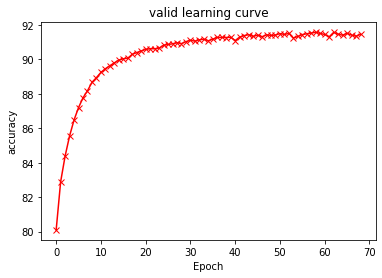

In [ ]:
super_backbone = Backbone(super_preprocessor.embedding_matrix, **net_config)
super_header = Header(**header_config)

run_training(super_train_loader, super_valid_loader, super_backbone, super_header, EPOCH_NUM, lr, device, MODEL_DIR2, scheduler = None)

# ***Testing***

In [ ]:
def run_testing(test_loader, backbone, header, device, output_path):
  with open(output_path, 'w') as f:
    backbone.eval()
    header.eval()
    writer = csv.writer(f)
    writer.writerow(['id', 'label'])
    with torch.no_grad():
      for i, (idx_list, lengths, texts) in enumerate(test_loader):
        lengths, inputs = lengths.to(device), texts.to(device)
        if not backbone is None:
          inputs = backbone(inputs)
        soft_predicted = header(inputs, lengths)
        hard_predicted = (soft_predicted >= 0.5).int()
        for i, p in zip(idx_list, hard_predicted):
          writer.writerow([str(i.item()), str(p.item())])

# ***Pseudo Labeling Test and submit file***

In [ ]:
EXP_name = "SuperCode"
pred_file = f'{EXP_name}-pred.csv'
run_testing(test_loader, super_backbone, super_header, device, pred_file)

In [ ]:
from google.colab import files
files.download(pred_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# ***Make a submission file***

# ***(Note: In principle, you don't need to modify this part, and please make sure that you follow the correct format of the produced files.)***

In [ ]:
EXP_name = "SampleCode"
pred_file = f'{EXP_name}-pred.csv'
run_testing(test_loader, backbone, header, device, pred_file)

In [ ]:
from google.colab import files
files.download(pred_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# ***Q5***

In [ ]:
!gdown --id "1hW0UvoM7aU6KRSXLJlkFkDW80O1Fiopo" --output 'testQ51_2.csv'
testQ5_idx, testQ5_text = load_test('testQ51_2.csv')
testQ5_dataset = TwitterDataset(testQ5_idx, testQ5_text, None, preprocessor)
testQ5_loader = torch.utils.data.DataLoader(dataset = testQ5_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = False,
                                            collate_fn = testQ5_dataset.collate_fn,
                                            num_workers = 8)
EXP_name = "tsetQ5"
pred_file = f'{EXP_name}-pred.csv'
run_testing(testQ5_loader, backbone, header, device, pred_file)

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1hW0UvoM7aU6KRSXLJlkFkDW80O1Fiopo
To: /content/testQ51_2.csv
100% 167/167 [00:00<00:00, 231kB/s]


# ***model Path***

In [ ]:
!gdown --id "1gGb2JHAP2pjqquxD3tKmvXxce146YVjI" --output 'model without pseudo labeling.pth'
!gdown --id "1045jFPa9SoLnkrVHnKNqDUtjIiHZfzYJ" --output 'model pseudo labeling.pth'

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1gGb2JHAP2pjqquxD3tKmvXxce146YVjI
To: /content/model without pseudo labeling.pth
100% 11.7M/11.7M [00:00<00:00, 153MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1045jFPa9SoLnkrVHnKNqDUtjIiHZfzYJ
To: /content/model pseudo labeling.pth
100% 11.7M/11.7M [00:00<00:00, 70.5MB/s]


# Good luck for your programming assignments!
If you have any questions, feel free to send e-mails to ntueemlta2022@gmail.com / b08202033@ntu.edu.tw. Of course, welcome to make use of the TA hours as well.